In [107]:
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re
from sklearn.model_selection import StratifiedKFold
import pickle

## Import data

In [108]:
df = pd.read_csv('outputs/ala1_trials_clean.csv')
df = df.rename(columns={'project_name': 'basis', 'cluster__n_clusters': 'n', 'test_mean': 'y'}).\
loc[:, ['basis', 'y', 'n']]

## Scale predictors



In [109]:
# to_log = ['n']
# for col in to_log: 
#     df.loc[:, col] = np.log(df[col])

to_scale = ['n']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_s' for x in to_scale])
df = df.join(vars_scaled)
df.T

,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,336
basis,psi,rmsd,phipsi,phipsi,phi,positions,rmsd,phi,psi,positions,...,phipsi,rmsd,psi,positions,rmsd,rmsd,phipsi,rmsd,rmsd,rmsd
y,1.79637,1.70957,3.27798,3.28693,1.98877,3.29715,1.70869,1.98756,1.79831,3.16998,...,3.29081,1.71039,1.79486,3.31378,1.71251,1.70886,3.28592,1.71229,1.71155,1.70997
n,77,554,97,95,362,440,942,169,96,33,...,274,156,519,390,150,628,292,127,155,47
n_s,0.0638945,0.547667,0.0841785,0.0821501,0.352941,0.432049,0.941176,0.157201,0.0831643,0.0192698,...,0.263692,0.144016,0.51217,0.381339,0.137931,0.622718,0.281947,0.114604,0.143002,0.0334686


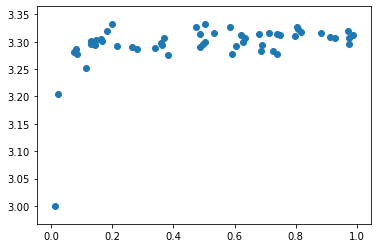

In [110]:
x = df.loc[df['basis']=='phipsi', 'n_s']
y = df.loc[df['basis']=='phipsi', 'y']
plt.scatter(x, y)

## Create design matrix

In [111]:
y = df.loc[:, 'y']
X = df.loc[:, df.columns.difference(['y'])]
X_c = pt.dmatrix('~ 0 + n_s + C(basis)', data=df, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))

## Model fitting functions

In [112]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1 # proportion of observations to use as inducing variables
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type.lower()=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type.lower()=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type.lower()=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type.lower()=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        print(type(num_Xu))
        print(type(X_a))
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

## Fit mml model

In [113]:
gp, mp, model = fit_model_1(y, X_c, kernel_type='rbf')

<class 'int'>
<class 'numpy.ndarray'>


/Users/robertarbon/opt/miniconda3/envs/analysis/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 717.57, ||grad|| = 0.34634: 100%|██████████| 110/110 [00:00<00:00, 117.53it/s] 


## Plot MML model

Create new data matrix

In [114]:
# Create mesh
n_new = np.arange(0, 1000, 10)
bases = X['basis'].unique()
x1, x2 = np.meshgrid(n_new, bases)

# scale n: 
# scaler_new = preprocessing.MinMaxScaler()
x1_s = scaler.transform(x1.reshape(-1, 1))

x1, x1_s, x2 = x1.flatten(), x1_s.flatten(), x2.flatten()

# Data frame: 
X_new = pd.DataFrame({'n_s': x1_s, 'basis': x2, 'n': x1}, index=np.arange(len(x2)))

# Make design matrix
X_new_c = pt.dmatrix('~ 0 + n_s + C(basis)', data=X_new, return_type='dataframe')
X_new_c = X_new_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))

In [115]:
# Get predictions for evalution
with model:
    # predict latent
    mu, var = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=False)
    sd_f = np.sqrt(var)

    # predict target (includes noise)
    _, var = gp.predict(X_new_c.values, point=mp, diag=True,pred_noise=True)
    sd_y = np.sqrt(var)

# put in data frame
pred = pd.DataFrame({'f_pred': mu, 'sd_f': sd_f, 'sd_y': sd_y})
pred = pred.join(X_new)

Create lb and ub for plotting

In [116]:
pred.loc[:, 'lb'] = pred['f_pred']-2*pred['sd_f']
pred.loc[:, 'ub'] = pred['f_pred']+2*pred['sd_f']

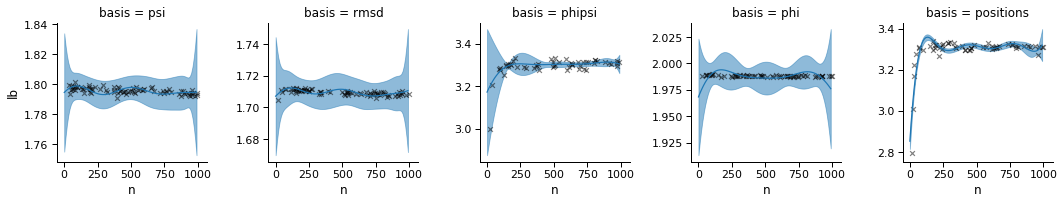

In [117]:
with sns.plotting_context('paper', font_scale=1.25):
    g = sns.FacetGrid(data=pred, col='basis', sharey=False)
    g.map(plt.plot, 'n', 'f_pred')
    g.map(plt.fill_between, 'n', 'lb', 'ub', alpha=0.5 )
    # plot the original data
    for ax, col in zip(g.axes[0, :].flatten(), g.col_names):
        idx = X['basis']==col
        ax.scatter(X.loc[idx, 'n'], y[idx], marker='x', color='k', alpha=0.5)
    
#     g.map(plt.scatter, '')
#     plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)